In [27]:
# Dataset

import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms


class UCSDPed2Dataset(Dataset):
    def __init__(self, root_dir, sequence_length=5, image_size=128, mode="train"):
        self.sequence_length = sequence_length
        self.image_size = image_size
        self.mode = mode

        if mode == "train":
            self.video_dir = os.path.join(root_dir, "train")
        else:
            self.video_dir = os.path.join(root_dir, "test")

        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor()
        ])

        self.samples = []
        self._prepare_samples()

    def _prepare_samples(self):
        video_folders = sorted(os.listdir(self.video_dir))

        for video in video_folders:
            video_path = os.path.join(self.video_dir, video)

            if not os.path.isdir(video_path):
                continue

            frames = sorted([
                f for f in os.listdir(video_path)
                if f.lower().endswith((".jpg", ".png", ".tif"))
            ])

            for i in range(len(frames) - self.sequence_length):
                self.samples.append((
                    video_path,
                    frames[i:i + self.sequence_length],
                    frames[i + self.sequence_length]
                ))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        video_path, input_frames, target_frame = self.samples[idx]

        input_tensor = []
        for f in input_frames:
            img = Image.open(os.path.join(video_path, f)).convert("L")
            img = self.transform(img)
            input_tensor.append(img)

        input_tensor = torch.stack(input_tensor, dim=0)

        target_img = Image.open(
            os.path.join(video_path, target_frame)
        ).convert("L")
        target_img = self.transform(target_img)

        return input_tensor, target_img


In [28]:
# Model

import torch.nn as nn


class CNNEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.encoder(x)


class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.conv = nn.Conv2d(
            input_dim + hidden_dim,
            4 * hidden_dim,
            3,
            padding=1
        )

    def forward(self, x, h, c):
        combined = torch.cat([x, h], dim=1)
        i, f, o, g = torch.split(self.conv(combined), self.hidden_dim, dim=1)

        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        o = torch.sigmoid(o)
        g = torch.tanh(g)

        c = f * c + i * g
        h = o * torch.tanh(c)
        return h, c


class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.cell = ConvLSTMCell(input_dim, hidden_dim)

    def forward(self, x):
        B, T, C, H, W = x.size()
        h = torch.zeros(B, C, H, W, device=x.device)
        c = torch.zeros_like(h)

        for t in range(T):
            h, c = self.cell(x[:, t], h, c)

        return h


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(x)


class FutureFramePredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = CNNEncoder()
        self.convlstm = ConvLSTM(128, 128)
        self.decoder = Decoder()

    def forward(self, x):
        encoded = torch.stack(
            [self.encoder(x[:, t]) for t in range(x.size(1))],
            dim=1
        )
        h = self.convlstm(encoded)
        return self.decoder(h)


In [29]:
# Training

from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = FutureFramePredictor().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_dataset = UCSDPed2Dataset(
    root_dir="../datasets/UCSDped2",
    sequence_length=5,
    image_size=128,
    mode="train"
)

train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=0
)

num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, target in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs = inputs.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        pred = model(inputs)
        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1} Avg Loss: {running_loss / len(train_loader):.6f}")

# ✅ SAVE MODEL
torch.save(model.state_dict(), "baseline_ucsd_ped2.pth")


Epoch 1/30: 100%|████████████████████████████████████████████████████████████████████| 618/618 [11:16<00:00,  1.09s/it]


Epoch 1 Avg Loss: 0.006597


Epoch 2/30: 100%|████████████████████████████████████████████████████████████████████| 618/618 [11:14<00:00,  1.09s/it]


Epoch 2 Avg Loss: 0.001119


Epoch 3/30: 100%|████████████████████████████████████████████████████████████████████| 618/618 [11:14<00:00,  1.09s/it]


Epoch 3 Avg Loss: 0.000777


Epoch 4/30: 100%|████████████████████████████████████████████████████████████████████| 618/618 [11:14<00:00,  1.09s/it]


Epoch 4 Avg Loss: 0.000628


Epoch 5/30: 100%|████████████████████████████████████████████████████████████████████| 618/618 [11:07<00:00,  1.08s/it]


Epoch 5 Avg Loss: 0.000547


Epoch 6/30: 100%|████████████████████████████████████████████████████████████████████| 618/618 [10:48<00:00,  1.05s/it]


Epoch 6 Avg Loss: 0.000491


Epoch 7/30: 100%|████████████████████████████████████████████████████████████████████| 618/618 [10:49<00:00,  1.05s/it]


Epoch 7 Avg Loss: 0.000450


Epoch 8/30: 100%|████████████████████████████████████████████████████████████████████| 618/618 [10:35<00:00,  1.03s/it]


Epoch 8 Avg Loss: 0.000418


Epoch 9/30: 100%|████████████████████████████████████████████████████████████████████| 618/618 [10:55<00:00,  1.06s/it]


Epoch 9 Avg Loss: 0.000391


Epoch 10/30: 100%|███████████████████████████████████████████████████████████████████| 618/618 [10:48<00:00,  1.05s/it]


Epoch 10 Avg Loss: 0.000368


Epoch 11/30: 100%|███████████████████████████████████████████████████████████████████| 618/618 [10:39<00:00,  1.03s/it]


Epoch 11 Avg Loss: 0.000347


Epoch 12/30: 100%|███████████████████████████████████████████████████████████████████| 618/618 [10:51<00:00,  1.05s/it]


Epoch 12 Avg Loss: 0.000330


Epoch 13/30: 100%|███████████████████████████████████████████████████████████████████| 618/618 [11:27<00:00,  1.11s/it]


Epoch 13 Avg Loss: 0.000314


Epoch 14/30: 100%|███████████████████████████████████████████████████████████████████| 618/618 [14:59<00:00,  1.46s/it]


Epoch 14 Avg Loss: 0.000300


Epoch 15/30: 100%|███████████████████████████████████████████████████████████████████| 618/618 [10:39<00:00,  1.04s/it]


Epoch 15 Avg Loss: 0.000288


Epoch 16/30: 100%|███████████████████████████████████████████████████████████████████| 618/618 [10:35<00:00,  1.03s/it]


Epoch 16 Avg Loss: 0.000276


Epoch 17/30: 100%|███████████████████████████████████████████████████████████████████| 618/618 [10:37<00:00,  1.03s/it]


Epoch 17 Avg Loss: 0.000266


Epoch 18/30: 100%|███████████████████████████████████████████████████████████████████| 618/618 [10:35<00:00,  1.03s/it]


Epoch 18 Avg Loss: 0.000256


Epoch 19/30: 100%|███████████████████████████████████████████████████████████████████| 618/618 [10:34<00:00,  1.03s/it]


Epoch 19 Avg Loss: 0.000248


Epoch 20/30: 100%|███████████████████████████████████████████████████████████████████| 618/618 [10:36<00:00,  1.03s/it]


Epoch 20 Avg Loss: 0.000240


Epoch 21/30: 100%|███████████████████████████████████████████████████████████████████| 618/618 [10:39<00:00,  1.04s/it]


Epoch 21 Avg Loss: 0.000233


Epoch 22/30: 100%|███████████████████████████████████████████████████████████████████| 618/618 [10:38<00:00,  1.03s/it]


Epoch 22 Avg Loss: 0.000226


Epoch 23/30: 100%|███████████████████████████████████████████████████████████████████| 618/618 [10:35<00:00,  1.03s/it]


Epoch 23 Avg Loss: 0.000219


Epoch 24/30: 100%|███████████████████████████████████████████████████████████████████| 618/618 [10:35<00:00,  1.03s/it]


Epoch 24 Avg Loss: 0.000214


Epoch 25/30: 100%|███████████████████████████████████████████████████████████████████| 618/618 [10:33<00:00,  1.03s/it]


Epoch 25 Avg Loss: 0.000207


Epoch 26/30: 100%|███████████████████████████████████████████████████████████████████| 618/618 [10:36<00:00,  1.03s/it]


Epoch 26 Avg Loss: 0.000202


Epoch 27/30: 100%|███████████████████████████████████████████████████████████████████| 618/618 [10:38<00:00,  1.03s/it]


Epoch 27 Avg Loss: 0.000197


Epoch 28/30: 100%|███████████████████████████████████████████████████████████████████| 618/618 [10:42<00:00,  1.04s/it]


Epoch 28 Avg Loss: 0.000193


Epoch 29/30: 100%|███████████████████████████████████████████████████████████████████| 618/618 [10:35<00:00,  1.03s/it]


Epoch 29 Avg Loss: 0.000189


Epoch 30/30: 100%|███████████████████████████████████████████████████████████████████| 618/618 [10:36<00:00,  1.03s/it]

Epoch 30 Avg Loss: 0.000184


In [30]:
# testing

test_dataset = UCSDPed2Dataset(
    root_dir="../datasets/UCSDped2",
    sequence_length=5,
    image_size=128,
    mode="test"
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False
)

model.load_state_dict(torch.load("baseline_ucsd_ped2.pth", map_location=device))
model.eval()

errors = []

with torch.no_grad():
    for inputs, target in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        target = target.to(device)

        pred = model(inputs)
        mse = torch.mean((pred - target) ** 2).item()
        errors.append(mse)


Testing: 100%|█████████████████████████████████████████████████████████████████████| 1950/1950 [04:01<00:00,  8.07it/s]


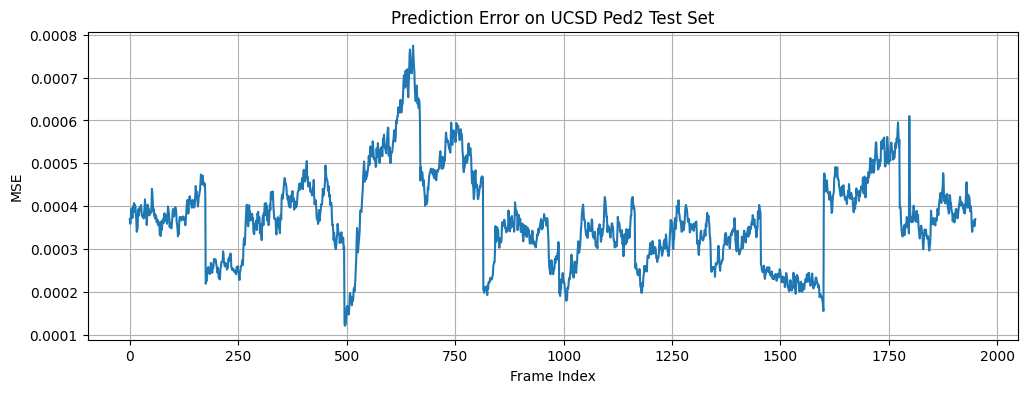

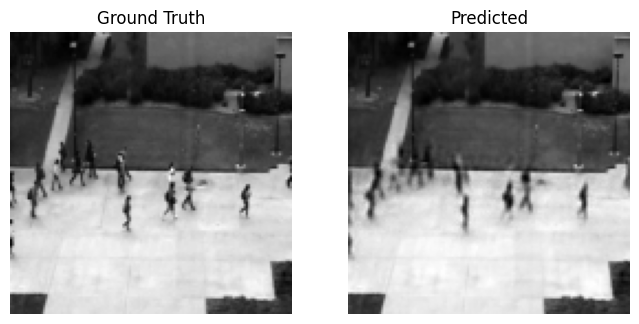

In [31]:
# visualization

import matplotlib.pyplot as plt

# Error curve
plt.figure(figsize=(12,4))
plt.plot(errors)
plt.title("Prediction Error on UCSD Ped2 Test Set")
plt.xlabel("Frame Index")
plt.ylabel("MSE")
plt.grid()
plt.show()

# Frame visualization
with torch.no_grad():
    inputs, target = test_dataset[200]
    inputs = inputs.unsqueeze(0).to(device)
    target = target.unsqueeze(0).to(device)

    pred = model(inputs)

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.title("Ground Truth")
    plt.imshow(target[0,0].cpu(), cmap="gray")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title("Predicted")
    plt.imshow(pred[0,0].cpu(), cmap="gray")
    plt.axis("off")
    plt.show()
